# DMRG : Modern MPS version

Edited by [Min Long](https://quantummc.xyz/members/min-long/), October.2023.

This is a notebook modern DMRG algorithm written in Matrix product states(MPS) formalism. The code shown in this notebook is adapted from Internet and revised my Min Long.

For further information, one can read the reference articles of this notebook by Schollwoeck [arXiv:1008.3477](https://arxiv.org/abs/1008.3477v2).

In [2]:
#####################################################
# Simple DMRG code using MPS/MPO representations    #
# Ian McCulloch August 2017                         #
#####################################################

import numpy as np
import scipy
import scipy.sparse.linalg
import scipy.sparse as sparse
import math

## Explaination of the variables
- W : Matrix product operator form of the Heisenberg chain
- A : Left caconical state
- B : Right caconical state
- E : Left vacum state to store the information of contraction from left at each step
- F : Right vacuum state with same use


In [3]:

## initial E and F matrices for the left and right vacuum states
def initial_E(W):
    E = np.zeros((W.shape[0], 1, 1))
    E[0] = 1
    return E


def initial_F(W):
    F = np.zeros((W.shape[1], 1, 1))
    F[-1] = 1
    return F

### Contraction function

Basically, the contraction is performed step be step. At nth site, the contraction is performed as  showned below


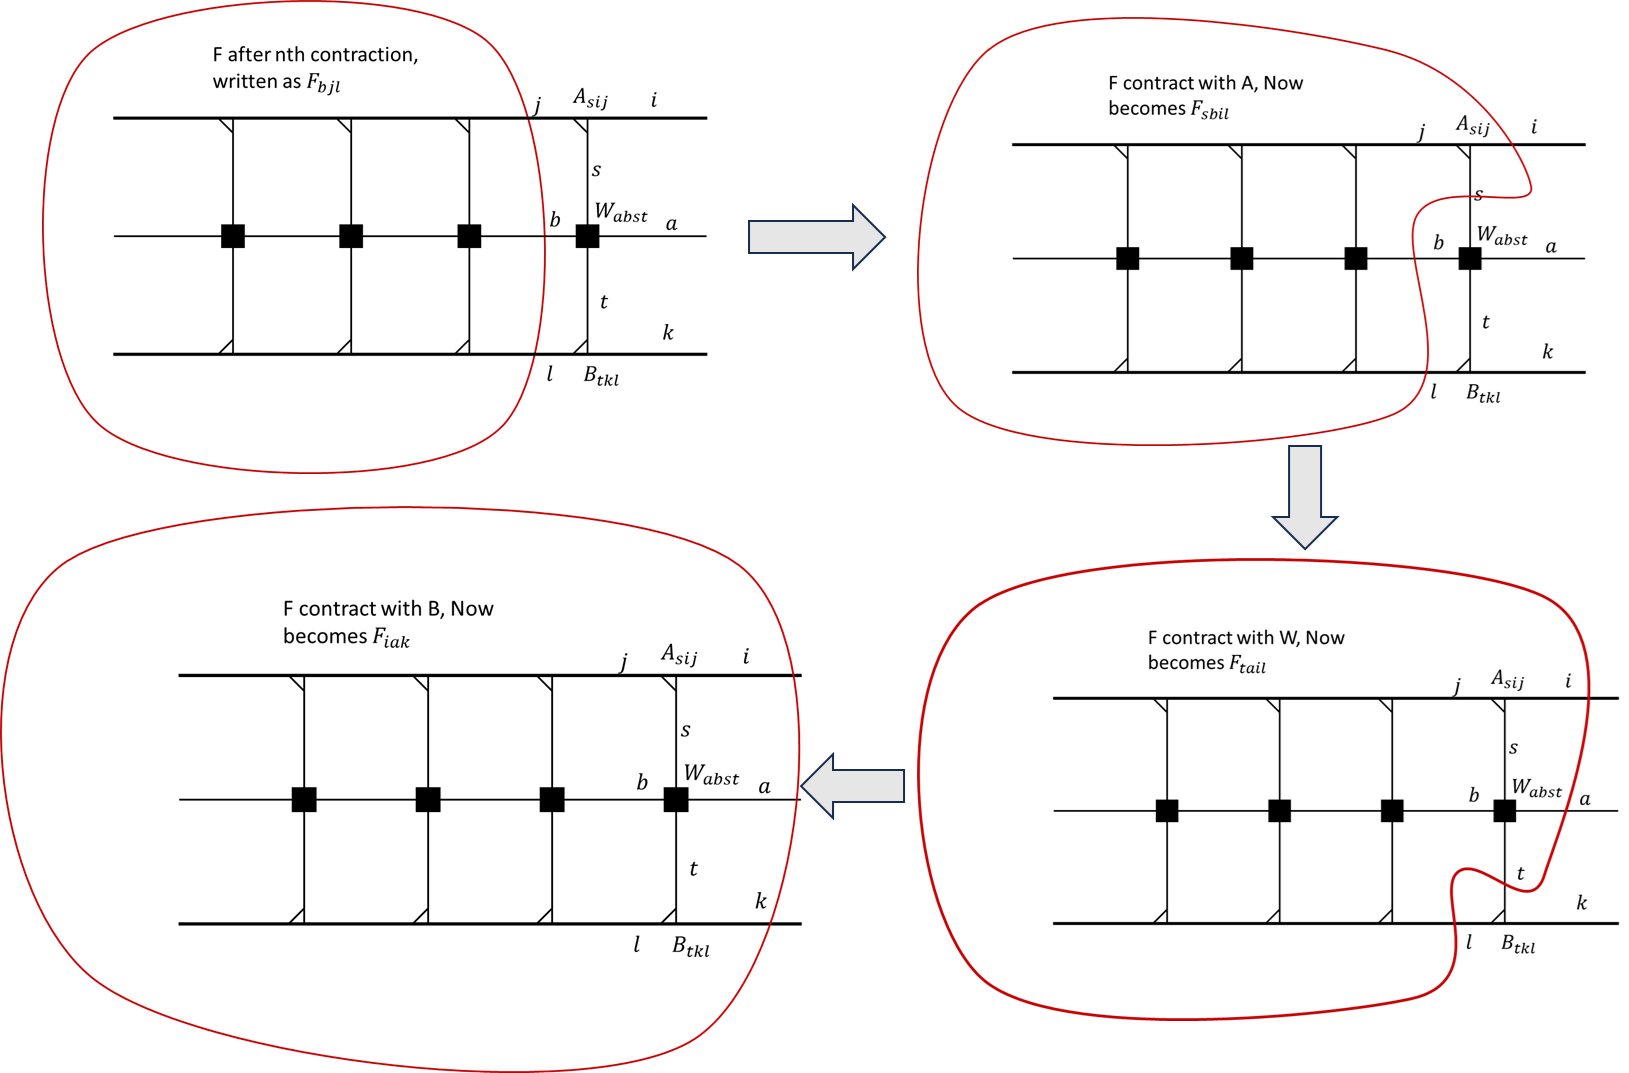

In [4]:

def contract_from_right(W, A, F, B):
    # the einsum function doesn't appear to optimize the contractions properly,
    # so we split it into individual summations in the optimal order
    # return np.einsum("abst,sij,bjl,tkl->aik",W,A,F,B, optimize=True)
    Temp = np.einsum("sij,bjl->sbil", A, F)
    Temp = np.einsum("sbil,abst->tail", Temp, W)
    return np.einsum("tail,tkl->aik", Temp, B)


def contract_from_left(W, A, E, B):
    # the einsum function doesn't appear to optimize the contractions properly,
    # so we split it into individual summations in the optimal order
    # return np.einsum("abst,sij,aik,tkl->bjl",W,A,E,B, optimize=True)
    Temp = np.einsum("sij,aik->sajk", A, E)
    Temp = np.einsum("sajk,abst->tbjk", Temp, W)
    return np.einsum("tbjk,tkl->bjl", Temp, B)


# construct the F-matrices for all sites except the first
def construct_F(Alist, MPO, Blist):
    F = [initial_F(MPO[-1])]

    for i in range(len(MPO) - 1, 0, -1):
        F.append(contract_from_right(MPO[i], Alist[i], F[-1], Blist[i]))
    return F


def construct_E(Alist, MPO, Blist):
    return [initial_E(MPO[0])]

def Expectation(AList, MPO, BList):
    E = [[[1]]]
    for i in range(0, len(MPO)):
        E = contract_from_left(MPO[i], AList[i], E, BList[i])
    return E[0][0][0]


### Coarse grainning and truncation function

In [5]:

# 2-1 coarse-graining of two site MPO into one site
def coarse_grain_MPO(W, X):
    return np.reshape(np.einsum("abst,bcuv->acsutv", W, X),
                      [W.shape[0], X.shape[1],
                       W.shape[2] * X.shape[2],
                       W.shape[3] * X.shape[3]])


def product_W(W1, W2):
    return np.reshape(np.einsum("abst,cdtu->acbdsu", W1, W2), [W1.shape[0] * W2.shape[0],
                                                               W1.shape[1] * W2.shape[1],
                                                               W1.shape[2], W2.shape[3]])


def product_MPO(M1, M2):
    assert len(M1) == len(M2)
    Result = []
    for i in range(0, len(M1)):
        Result.append(product_W(M1[i], M2[i]))
    return Result


# 2-1 coarse-graining of two-site MPS into one site
def coarse_grain_MPS(A, B):
    return np.reshape(np.einsum("sij,tjk->stik", A, B),
                      [A.shape[0] * B.shape[0], A.shape[1], B.shape[2]])


def fine_grain_MPS(A, dims):
    assert A.shape[0] == dims[0] * dims[1]
    Theta = np.transpose(np.reshape(A, dims + [A.shape[1], A.shape[2]]),
                         (0, 2, 1, 3))
    M = np.reshape(Theta, (dims[0] * A.shape[1], dims[1] * A.shape[2]))
    U, S, V = np.linalg.svd(M, full_matrices=0)
    U = np.reshape(U, (dims[0], A.shape[1], -1))
    V = np.transpose(np.reshape(V, (-1, dims[1], A.shape[2])), (1, 0, 2))
    # assert U is left-orthogonal
    # assert V is right-orthogonal
    # print(np.dot(V[0],np.transpose(V[0])) + np.dot(V[1],np.transpose(V[1])))
    return U, S, V


def truncate_MPS(U, S, V, m):
    m = min(len(S), m)
    trunc = np.sum(S[m:])
    S = S[0:m]
    U = U[:, :, 0:m]
    V = V[:, 0:m, :]
    return U, S, V, trunc, m

### Work flow : Procedure of DMRG

In [6]:
class HamiltonianMultiply(sparse.linalg.LinearOperator):
    def __init__(self, E, W, F):
        self.E = E
        self.W = W
        self.F = F
        self.dtype = np.dtype('d')
        self.req_shape = [W.shape[2], E.shape[1], F.shape[2]]
        self.size = self.req_shape[0] * self.req_shape[1] * self.req_shape[2]
        self.shape = [self.size, self.size]

    def _matvec(self, A):
        # the einsum function doesn't appear to optimize the contractions properly,
        # so we split it into individual summations in the optimal order
        # R = np.einsum("aij,sik,abst,bkl->tjl",self.E,np.reshape(A, self.req_shape),
        #              self.W,self.F, optimize=True)
        R = np.einsum("aij,sik->ajsk", self.E, np.reshape(A, self.req_shape))
        R = np.einsum("ajsk,abst->bjtk", R, self.W)
        R = np.einsum("bjtk,bkl->tjl", R, self.F)
        return np.reshape(R, -1)


## optimize a single site given the MPO matrix W, and tensors E,F
def optimize_site(A, W, E, F):
    H = HamiltonianMultiply(E, W, F)
    # we choose tol=1E-8 here, which is OK for small calculations.
    # to bemore robust, we should take the tol -> 0 towards the end
    # of the calculation.
    E, V = sparse.linalg.eigsh(H, 1, v0=A, which='SA', tol=1E-8)
    return (E[0], np.reshape(V[:, 0], H.req_shape))


def optimize_two_sites(A, B, W1, W2, E, F, m, dir):
    W = coarse_grain_MPO(W1, W2)
    AA = coarse_grain_MPS(A, B)
    H = HamiltonianMultiply(E, W, F)
    E, V = sparse.linalg.eigsh(H, 1, v0=AA, which='SA')
    AA = np.reshape(V[:, 0], H.req_shape)
    A, S, B = fine_grain_MPS(AA, [A.shape[0], B.shape[0]])
    A, S, B, trunc, m = truncate_MPS(A, S, B, m)
    if (dir == 'right'):
        B = np.einsum("ij,sjk->sik", np.diag(S), B)
    else:
        assert dir == 'left'
        A = np.einsum("sij,jk->sik", A, np.diag(S))
    return E[0], A, B, trunc, m


def two_site_dmrg(MPS, MPO, m, sweeps):
    E = construct_E(MPS, MPO, MPS)
    F = construct_F(MPS, MPO, MPS)
    F.pop()
    for sweep in range(0, int(sweeps / 2)):
        for i in range(0, len(MPS) - 2):
            Energy, MPS[i], MPS[i + 1], trunc, states = optimize_two_sites(MPS[i], MPS[i + 1],
                                                                           MPO[i], MPO[i + 1],
                                                                           E[-1], F[-1], m, 'right')
            print("Sweep {:} Sites {:},{:}    Energy {:16.12f}    States {:4} Truncation {:16.12f}"
                  .format(sweep * 2, i, i + 1, Energy, states, trunc))
            E.append(contract_from_left(MPO[i], MPS[i], E[-1], MPS[i]))
            F.pop();
        for i in range(len(MPS) - 2, 0, -1):
            Energy, MPS[i], MPS[i + 1], trunc, states = optimize_two_sites(MPS[i], MPS[i + 1],
                                                                           MPO[i], MPO[i + 1],
                                                                           E[-1], F[-1], m, 'left')
            print("Sweep {} Sites {},{}    Energy {:16.12f}    States {:4} Truncation {:16.12f}"
                  .format(sweep * 2 + 1, i, i + 1, Energy, states, trunc))
            F.append(contract_from_right(MPO[i + 1], MPS[i + 1], F[-1], MPS[i + 1]))
            E.pop();
    return MPS


d = 2  # local bond dimension
N = 100  # number of sites
D = 10 # virtue bond dimension

InitialA1 = np.zeros((d, 1, 1))
InitialA1[0, 0, 0] = 1
InitialA2 = np.zeros((d, 1, 1))
InitialA2[1, 0, 0] = 1

## initial state |01010101>
MPS = [InitialA1, InitialA2] * int(N / 2)

## Local operators
I = np.identity(2)
Z = np.zeros((2, 2))
Sz = np.array([[0.5, 0],
               [0, -0.5]])
Sp = np.array([[0, 0],
               [1, 0]])
Sm = np.array([[0, 1],
               [0, 0]])

## Hamiltonian MPO
W = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z],
              [Z, Z, Z, Z, Sz],
              [Z, Z, Z, Z, Sm],
              [Z, Z, Z, Z, Sp],
              [Z, Z, Z, Z, I]])

Wfirst = np.array([[I, Sz, 0.5 * Sp, 0.5 * Sm, Z]])

Wlast = np.array([[Z], [Sz], [Sm], [Sp], [I]])

# the complete MPO
MPO = [Wfirst] + ([W] * (N - 2)) + [Wlast]

HamSquared = product_MPO(MPO, MPO)

# 8 sweeps with m=10 states

MPS = two_site_dmrg(MPS, MPO, D, 8)

Energy = Expectation(MPS, MPO, MPS)
print("Final energy expectation value {}".format(Energy))

H2 = Expectation(MPS, HamSquared, MPS)
print("variance = {:16.12f}".format(H2 - Energy * Energy))

Sweep 0 Sites 0,1    Energy -25.059016994375    States    2 Truncation   0.000000000000
Sweep 0 Sites 1,2    Energy -25.189692620786    States    2 Truncation   0.000000000000
Sweep 0 Sites 2,3    Energy -25.395800958670    States    2 Truncation   0.000000000000
Sweep 0 Sites 3,4    Energy -25.560586239348    States    2 Truncation   0.000000000000
Sweep 0 Sites 4,5    Energy -25.743669962857    States    2 Truncation   0.000000000000
Sweep 0 Sites 5,6    Energy -25.917602338044    States    2 Truncation   0.000000000000
Sweep 0 Sites 6,7    Energy -26.095754582728    States    2 Truncation   0.000000000000
Sweep 0 Sites 7,8    Energy -26.271867353000    States    2 Truncation   0.000000000000
Sweep 0 Sites 8,9    Energy -26.448938381096    States    2 Truncation   0.000000000000
Sweep 0 Sites 9,10    Energy -26.625551828355    States    2 Truncation   0.000000000000
Sweep 0 Sites 10,11    Energy -26.802381755193    States    2 Truncation   0.000000000000
Sweep 0 Sites 11,12    Energy